# Group 7 - MAPD-B PROJECT: Distributed algorithms
## K-Means: Minibatch using pyspark
Team members: Ausilio Lorenzo, Jafarpour Farshad, Martemucci Walter, Prodan George

### Initialize spark, imports 

In [1]:
import findspark
findspark.init('/usr/local/spark/')

In [2]:
# check some of the env variables
!env | grep -i spark

VIRTUAL_ENV=/usr/local/environments/spark_env
PYSPARK_PYTHON=/usr/local/environments/spark_env/bin/python3
SPARK_HOME=/usr/local/spark/
PATH=/usr/local/environments/spark_env/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/usr/local/spark/bin


In [38]:
from pyspark import SparkContext, SparkConf


master_url = "spark://10.67.22.172:7077"

conf = SparkConf()

conf.setAppName("KMeansMiniBatch")
conf.set("spark.blockManager.port", "10025")
conf.set("spark.driver.blockManager.port", "10026")
conf.set("spark.driver.port", "10027")  
conf.set("spark.cores.max", "12") 
conf.set("spark.executor.memory", "2g") 
conf.set("spark.driver.host", "10.67.22.172"); 
conf.setMaster(master_url)
sc = SparkContext(conf = conf)


Check the content of the SparkSession `spark` object

In [39]:
sc

<SparkContext master=spark://10.67.22.172:7077 appName=KMeansMiniBatch>

In [65]:
import numpy as np
import time 
from matplotlib import pyplot as plt 
import time
import numpy
import os

In [66]:
os.environ["PYSPARK_PYTHON"]="/usr/local/environments/spark_env/bin/python3"

In [28]:
def find_min(idx):
    distances = [np.linalg.norm(X[idx] - centroid, 2) for centroid in C]
    return np.argmin(distances)

In [62]:
def kmeans(use_spark=True, no_clusters=3, steps=1000, batch_size=400000):
    
    # 1: Given: k, mini-batch size b, iterations t, data set X
    # 2: Initialize each c ∈ C with an x picked randomly from X
    # 3: v ← 0
    k = no_clusters
    b = batch_size
    t = steps
    C = np.array([X[np.random.randint(0, len(X))] for _ in range(k)])
    v = np.zeros(len(C))
    Y = np.empty(len(X), dtype=np.int32)
    
    tic = time.time()
    
    for i in range(t):
            # 4: for i = 1 to t do
            # 5: M ← b examples picked randomly from X
            mini_batch_idx = np.random.choice(range(len(X)), size=b, replace=False)

            # 6: for x ∈ M do
            # 7: d[x] ← f (C, x) // Cache the center nearest to x
            # 8: end for
            # 9: for x ∈ M do
            # 10: c ← d[x] // Get cached center for this x
            # 11: v[c] ← v[c] + 1 // Update per-center counts
            # 12: η ← 1/v[c] // Get per-center learning rate
            # 13: c ← (1 − η)c + ηx // Take gradient step
            # 14: end for
            # 15: end for

            if use_spark:
                mini_batch = X[mini_batch_idx]
                dist_mini_batch_idx = sc.parallelize(mini_batch_idx)
                Y[mini_batch_idx] = dist_mini_batch_idx.map(
                                    lambda idx: np.argmin((C[:,0] - X[idx][0]) ** 2 + (C[:,1] - X[idx][1]) ** 2)
                                    ).collect()
            else:    
                # this is the classic implementation (https://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)
                for idx in mini_batch_idx:
                    Y[idx] = find_min(idx)
            for idx in mini_batch_idx:
                v[Y[idx]] += 1
                learning_rate = 1 / v[Y[idx]]
                C[Y[idx]] = (1 - learning_rate) * C[Y[idx]] + learning_rate * X[idx]

    toc = time.time()
    print('Computation time: ', toc - tic, ' seconds')
    return Y

### Experiment #1: random sampling on three distributions

Firstly, we have created a mock dataset in order to do several fast tests on the algorithm.

In [68]:
# generate mock dataset
c_1 = np.random.normal(0.5, 0.2, (1000000, 2))
c_2 = np.random.normal(1.0, 0.2, (1000000, 2))
c_3 = np.random.normal(-0.5, 0.2, (1000000, 2))
X = np.concatenate((c_1,c_2,c_3))

In [69]:
k = 3
b = 500000
t = 1000
C = np.array([X[np.random.randint(0, len(X))] for _ in range(k)])
v = np.zeros(len(C))
Y = np.empty(len(X), dtype=np.int32)

In [70]:
mini_batch_idx = np.random.choice(range(len(X)), size=b, replace=False)

tic = time.time()
for idx in mini_batch_idx:
    Y[idx] = find_min(idx)
toc = time.time()
print('time find centroids (classic):', toc - tic)


mini_batch_idx = np.random.choice(range(len(X)), size=b, replace=False)
tic = time.time()
mini_batch = X[mini_batch_idx]
dist_mini_batch_idx = sc.parallelize(mini_batch_idx)
Y[mini_batch_idx] = dist_mini_batch_idx.map(lambda idx: np.argmin((C[:,0] - X[idx][0]) ** 2 + (C[:,1] - X[idx][1]) ** 2)).collect()
toc = time.time()
print('time find centroids (by spark):', toc - tic)


time find centroids (classic): 9.117126226425171


22/06/15 15:22:28 WARN TaskSetManager: Stage 220 contains a task of very large size (1170 KiB). The maximum recommended task size is 1000 KiB.


time find centroids (by spark): 2.862954616546631


In [72]:
Y = kmeans(use_spark=True, steps=10)

Computation time:  55.02375936508179  seconds


In [71]:
Y = kmeans(use_spark=False, steps=10)

Computation time:  104.32673597335815  seconds


In [1]:
plt.plot(Y)
plt.ylim((-3,3))
plt.show()

NameError: name 'plt' is not defined

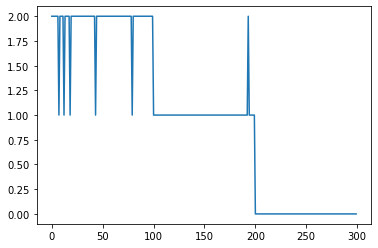

22/06/11 13:45:35 WARN HeartbeatReceiver: Removing executor 0 with no recent heartbeats: 67310777 ms exceeds timeout 120000 ms
22/06/11 13:45:35 ERROR TaskSchedulerImpl: Lost executor 0 on 192.168.144.128: Executor heartbeat timed out after 67310777 ms


In [86]:
plt.plot(Y)

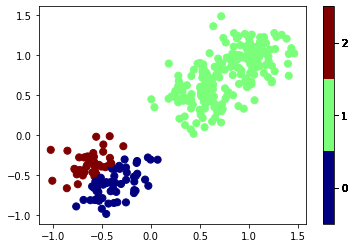

In [82]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors

# Define a colormap with the right number of colors
cmap = plt.cm.get_cmap('jet',max(Y)-min(Y)+1)

bounds = range(min(Y),max(Y)+2)
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.scatter(X[:,0], X[:,1], c=Y, s=50, cmap=cmap, norm=norm)

# Add a colorbar. Move the ticks up by 0.5, so they are centred on the colour.
cb=plt.colorbar(ticks=np.array(Y)+0.5)
cb.set_ticklabels(Y)

plt.show()

In [4]:
from sklearn.datasets import fetch_rcv1

train = fetch_rcv1(subset='train')
test = fetch_rcv1(subset='test')

X_train = train.data
X_test = test.data


y_train = train.target
y_test = test.target

### Stop the running Spark context

In [37]:
# 
sc.stop()

### Start Spark services

To start the Spark execution in the master and worker nodes, issue the following bash command on the master node:

In [ ]:
!$SPARK_HOME/sbin/start-all.sh

### Stop Spark services

To stop the Spark execution in the master and worker nodes, issue the following bash command on the master node:

In [5]:
!$SPARK_HOME/sbin/stop-all.sh

stopping org.apache.spark.deploy.worker.Worker
